In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from pathlib import Path
from collections import Counter
#
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#
from tqdm import tqdm
#
from problems import get_problems, filter_problems
from metrics import *
from utils import coords_map, grade_maps, get_board_setup, draw_moves, plot_mat, count_parameters, x_coords, y_coords

In [7]:
P_ROOT = Path("../data")
P_PROB = P_ROOT / "problems"
P_BOARD = P_ROOT / "boards/moonboard.png"
P_HOLDS = P_ROOT / "boards/holds"
setup_year = 2017
setup_angle = 45
#
minlen = 4
maxlen = 14
#
grade_names = ["6A+", "6B", "6B+", "6C", "6C+", "7A", "7A+", "7B", "7B+", "7C", "7C+"]
repsge = 10

In [8]:
probs = get_problems(P_PROB, setup_year, setup_angle)
print(len(probs))

probs = filter_problems(probs, repsge, grade_names, minlen, maxlen)
print(len(probs))

grade_to_num, num_to_grade = grade_maps(grade_names)

39466
13272


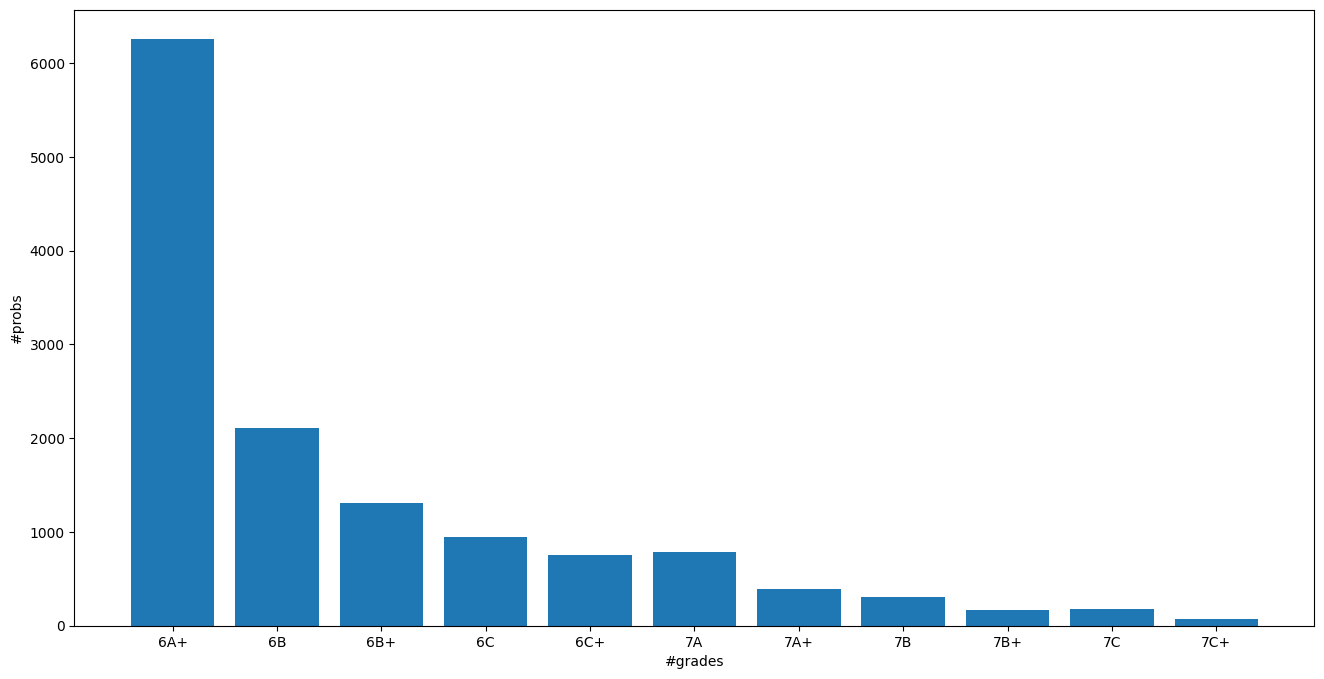

In [9]:
grades, nprobs = zip(*Counter(sorted([grade_to_num[p["grade"]] for p in probs])).items())
nprobs = np.array(nprobs)
grade_freqs =  nprobs / nprobs.sum()
class_weights = nprobs.sum() / nprobs

fig, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.bar(grades, nprobs)
#plt.yscale("log")
plt.ylabel("#probs")
plt.xlabel("#grades")
plt.xticks(grades, [num_to_grade[n] for n in grades])
plt.show()

In [10]:
coords_to_num = coords_map
num_to_coords = {v:k for k,v in coords_to_num.items()}
#
spec_to_num = {
    "<CLS>": max(num_to_coords.keys()) + 1,
    "<PAD>": max(num_to_coords.keys()) + 2
}
num_to_spec = {v:k for k,v in spec_to_num.items()}
#
tok_to_num = {**spec_to_num, **coords_to_num}
num_to_tok = {v:k for k,v in tok_to_num.items()}

In [12]:
def specify(sent, pad_to):
    """
        Add special tokens and pad
    """
    assert len(sent) > 1, "Sentency empty"
    assert len(sent) < pad_to, "Sentences too long!, Increase padding!"
    return ["<CLS>"] + sent + ["<PAD>"] * (pad_to - len(sent))

def maskify(sent):
    """
        Create mask
    """
    return [False if t != '<PAD>' else True for t in sent]
#[is_grade.squeeze()]
def encode(sent):
    return [tok_to_num[t] for t in sent]

def block_encode(sents):
    return [encode(s) for s in sents]

def decode(sent, drop_special=False):
    dec = [num_to_tok[n] for n in sent]
    if drop_special:
        dec = [t for t in dec if t not in spec_to_num]
    return dec

def block_decode(sents, drop_special=False):
    return [block_decode(s) for s in sents]

def block_specify(sents, pad_to):
    return [specify(sent, pad_to) for sent in sents]

def block_maskify(sents):
    return [maskify(sent) for sent in sents]

def blockify(sents, pad_to):
    X = [add_spec(sent, pad_to) for sent in sents]
    return X

In [13]:
coords_to_num = coords_map
num_to_coords = {v:k for k,v in coords_to_num.items()}
#
spec_to_num = {
    "<CLS>": max(num_to_coords.keys()) + 1,
    "<PAD>": max(num_to_coords.keys()) + 2
}
num_to_spec = {v:k for k,v in spec_to_num.items()}
#
tok_to_num = {**spec_to_num, **coords_to_num}
num_to_tok = {v:k for k,v in tok_to_num.items()}
#

In [14]:
Y = []
X = []
for p in probs:
    grade = grade_to_num[p["grade"]]
    Y.append(grade)
    moves = [move["description"].upper() for move in p["moves"]]
    X.append(moves)

dim = 15
X = block_specify(X, dim)
M = block_maskify(X)
X = block_encode(X)

X = np.array(X)
M = np.array(M)
Y = np.array(Y)

In [15]:
r_train = 0.85
n_train = int(r_train * len(probs))
#
idcs = np.arange(len(probs))
for _ in range(10):
    np.random.shuffle(idcs)
idcs_train = idcs[:n_train]
idcs_valid = idcs[n_train:]
#
X_train = X[idcs_train]
Y_train = Y[idcs_train]
M_train = M[idcs_train]
#
X_valid = X[idcs_valid]
Y_valid = Y[idcs_valid]
M_valid = M[idcs_valid]

In [16]:
def label_smoother(y_true, n_classes, n_smooth):
    y = torch.zeros(n_classes + n_smooth * 2)
    y[y_true + n_smooth] = 1        # y
    for smooth in range(1, n_smooth + 1):
        y[y_true + n_smooth + smooth] = 1/(3*smooth)
        y[y_true + n_smooth - smooth] = 1/(3*smooth)
    return y[n_smooth:len(y) - n_smooth]


class HoldDataset(Dataset):
    def __init__(self, X, Y, M, n_classes=None, n_smooth=None):
        self.M = torch.Tensor(M).bool()
        self.X = torch.Tensor(X).long()
        self.Y = torch.Tensor(Y).long()
        if n_smooth is not None:
            self.n_classes = n_classes
            self.n_smooth = n_smooth

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if self.n_smooth is None:
            return self.X[idx], self.Y[idx], self.M[idx]
        else:
            return self.X[idx], self.Y[idx], self.M[idx], label_smoother(self.Y[idx], self.n_classes, self.n_smooth)

In [17]:
n_classes = len(grade_names)
n_smooth = 2

ds_train = HoldDataset(X_train, Y_train, M_train, n_classes=n_classes, n_smooth=n_smooth)
ds_valid = HoldDataset(X_valid, Y_valid, M_valid, n_classes=n_classes, n_smooth=n_smooth)
#
dl_train = DataLoader(ds_train, batch_size=256, shuffle=True, drop_last=True)
dl_valid = DataLoader(ds_valid, batch_size=256, shuffle=False, drop_last=True)

In [18]:
x, y, m, ys = next(iter(dl_train))

In [19]:
class GradeTransformer(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, n_classes, n_tok):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.n_tok = n_tok
        #
        self.embedder = nn.Embedding(n_tok, d_model)
        #
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = d_model,
            nhead = n_heads,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, n_classes, bias=False),
        )
    def forward(self, x, src_key_padding_mask=None):
        x = self.embedder(x)
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = self.classifier(x[:, 0,:])
        return x

In [20]:
x,y,m,ys = next(iter(dl_train))

In [21]:
d_model = 32
n_heads = 8
n_layers = 4
n_classes = len(grade_to_num)
n_tok = len(tok_to_num)
#
model = GradeTransformer(d_model, n_heads, n_layers, n_classes, n_tok)
print(count_parameters(model))
model

TypeError: __init__() got an unexpected keyword argument 'batch_first'

In [ ]:
device = "cuda:0"
num_epochs = 31
model = model.to(device)
#
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=0.98)
loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.MSELoss()
for epoch_idx in range(num_epochs + 1):
    #
    model.train()
    n_tot = 0.
    n_cor = 0.
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    #
    Y_true = []
    Y_pred = []
    for x, y, m, ys in pbar:
        x = x.to(device)
        y = y.to(device)
        m = m.to(device)
        ys = ys.to(device)
        #
        optimizer.zero_grad()
        out = model.forward(x, m)
        loss = loss_fn(out, ys) 
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix(
            {'loss': loss.item(),
             'acc@0': soft_acuracy(y.cpu(), torch.argmax(out, dim=-1).cpu(), tol=0),
             "acc@1": soft_acuracy(y.cpu(), torch.argmax(out, dim=-1).cpu(), tol=1)
            }
        )
    
    if epoch_idx % 5 == 0 or epoch_idx == num_epochs:
        model.eval()
        L = 0.
        Y_true = []
        Y_pred = []
        step = 0
        for x, y, m, ys in dl_valid:
            x = x.to(device)
            y = y.to(device)
            m = m.to(device)
            ys = ys.to(device)
            with torch.no_grad():
                out = model.forward(x, m)
                loss = loss_fn(out, ys)
                L += loss.item()
                Y_pred.append(torch.argmax(out, dim=-1).cpu().numpy())
                Y_true.append(y.cpu().numpy())
                step += 1
        Y_true = np.array(Y_true).flatten()
        Y_pred = np.array(Y_pred).flatten()
        acc0 = soft_acuracy(Y_true, Y_pred, tol=0)
        acc1 = soft_acuracy(Y_true, Y_pred, tol=1)
        print("  loss: {:.3f} acc@0: {:.3f} acc@1: {:.3f}".format(L / step,acc0, acc1))

In [ ]:
model.eval()
L = 0.
Y_true = []
Y_pred = []
step = 0
for x, y, m, ys in dl_valid:
    x = x.to(device)
    y = y.to(device)
    m = m.to(device)
    ys = ys.to(device)
    with torch.no_grad():
        out = model.forward(x, m)
        loss = loss_fn(out, ys)
        L += loss.item()
        Y_pred.append(torch.argmax(out, dim=-1).cpu().numpy())
        Y_true.append(y.cpu().numpy())
        step += 1
Y_true = np.array(Y_true).flatten()
Y_pred = np.array(Y_pred).flatten()
acc0 = soft_acuracy(Y_true, Y_pred, tol=0)
acc1 = soft_acuracy(Y_true, Y_pred, tol=1)
print("  loss: {:.3f} acc@0: {:.3f} acc@1: {:.3f}".format(L / step,acc0, acc1))

In [ ]:
y_true = Y_true
y_pred = Y_pred
for tol in range(2):
    rep = soft_classification_report(y_true, y_pred, tol, target_names=grade_names, digits=3)
    print(rep)

In [ ]:
vocs = torch.Tensor(list(num_to_coords.keys())).long()
vocs = vocs.unsqueeze(0)
#
E = model.embedder(vocs.to(device)).detach().cpu().squeeze().numpy()
I = vocs.numpy()

In [ ]:
dim_x_tot = len(x_coords)**2
dim_y_tot = len(y_coords)**2
#
dim_x = len(x_coords)
dim_y = len(y_coords)

D = np.zeros((dim_y_tot, dim_x_tot))

for query_x_idx, query_x in enumerate(x_coords):
    for query_y_idx, query_y in enumerate(y_coords):
        #
        query_coord = query_x + query_y
        query_emb_idx = coords_to_num[query_coord]
        query_emb = E[query_emb_idx]
        #
        for x_idx, x in enumerate(x_coords):
            for y_idx, y in enumerate(y_coords):
                coord = x + y
                emb_idx = coords_to_num[coord]
                emb = E[emb_idx]
                #
                #d = np.abs(np.dot(query_emb, emb) / (np.linalg.norm(query_emb) * np.linalg.norm(emb)))
                d = np.linalg.norm(query_emb * emb)
                #
                d_idx_y = dim_y * query_y_idx + y_idx
                d_idx_x = dim_x * query_x_idx + x_idx
                
                #if query_emb_idx == emb_idx:
                #    d = 0
                
                D[d_idx_y, d_idx_x] = d

In [ ]:
sf = 2
plt.figure(figsize=(dim_x * sf, dim_y * sf))
plt.imshow(D)
plt.xticks(list(range(5, 121, 11)), x_coords)
plt.yticks(list(range(9, 324, 18)), y_coords)
plt.show()

# Projection

In [ ]:
from mpl_toolkits import mplot3d
from sklearn.manifold import TSNE
%matplotlib notebook

In [ ]:
model.eval()
L = 0.
Y_true = []
Y_pred = []
R = []
step = 0
for x, y, m, ys in dl_valid:
    x = x.to(device)
    y = y.to(device)
    m = m.to(device)
    ys = ys.to(device)
    with torch.no_grad():
        r = model.reppresentations(x, m)
        Y_true.append(y.cpu().numpy())
        R.append(r[:,0,:].detach().cpu().numpy())
        step += 1
Y_true = np.array(Y_true).flatten()
R = np.concatenate(R)
#
tsne = TSNE(n_components=3, perplexity=50)
R = tsne.fit_transform(R)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(R[:,0], R[:,1], R[:,2], c=Y_true, cmap='viridis');